# 5.4 Visualizing what convnets learn

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. are highly amenable to visualization, in large part because they’re __representations of visual concepts__. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations.
We won’t survey all of them, but we’ll cover three of the most accessible and useful ones:
* __Visualizing intermediate convnet outputs (intermediate activations)__—Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* __Visualizing convnets filters__—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* __Visualizing heatmaps of class activation in an image__—Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

For the first method—activation visualization—you’ll use the small convnet that you trained from scratch on the dogs-versus-cats classification problem in section 5.2. For the next two methods, you’ll use the VGG16 model introduced in section 5.3.

## 5.4.1 Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its __activation__, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network.You want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so __the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image__. Let’s start by loading the model that you saved in section 5.2:

In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_______________________________________

Next, you’ll get an input image—a picture of a cat, not part of the images the network was trained on.

In [2]:
# Preprocessing a single image
img_path = 'D:\\perso\\Deep-Learning-with-python\\dogs_vs_cats_small\\test\\cats\\cat.1700.jpg'

# Preprocesses the image
# into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Remember that the model was trained 
# on inputs that were preprocessed this way.
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


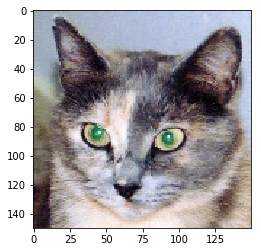

<Figure size 720x720 with 0 Axes>

In [4]:
# Displaying the test picture
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.figure(figsize=(10, 10))
plt.show()

In order to extract the feature maps you want to look at, you’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, you’ll use the Keras class Model. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models you’re familiar with, mapping the specified inputs to the specified outputs. What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential. For more information about the Model class, see section 7.1.

In [5]:
# Instantiating a model from an input tensor and a list of output tensors
from keras import models

# Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model.This is the first time you’ve encountered a multi-output model in this book: until now, the models you’ve seen have had exactly one input and one output.In the general case, a model can have any number of inputs and outputs. This one has one input and eight outputs: one output per layer activation.

In [6]:
# Running the model in predict mode

# Returns a list of five
# Numpy arrays: one array
# per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for the cat image input:

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It’s a 148 × 148 feature map with 32 channels. Let’s try plotting the __fourth channel__ of the activation of the first layer of the original model.

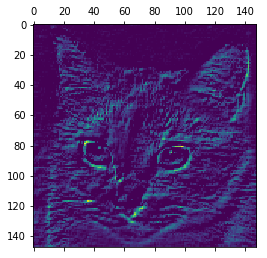

In [9]:
# Visualizing the fourth channel
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

This channel appears to encode a diagonal edge detector. Let’s try the __seventh channel__ but note that your own channels may vary, because the specific filters learned by convolution layers aren’t deterministic.

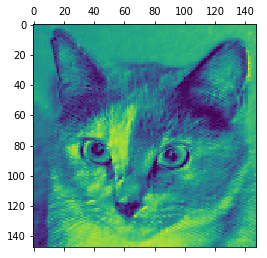

In [10]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

This one looks like a “bright green dot” detector, useful to encode cat eyes. At this point, let’s plot a complete visualization of all the activations in the network.You’ll extract and plot every channel in each of the eight activation maps, and you’ll stack the results in one big image tensor, with channels stacked side by side.

C:\Users\yannickr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


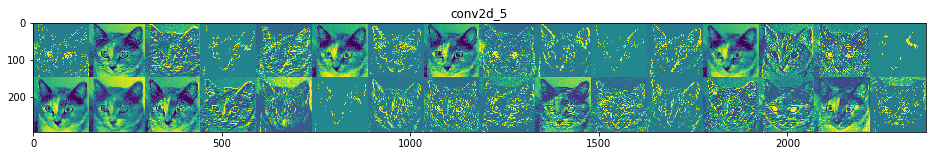

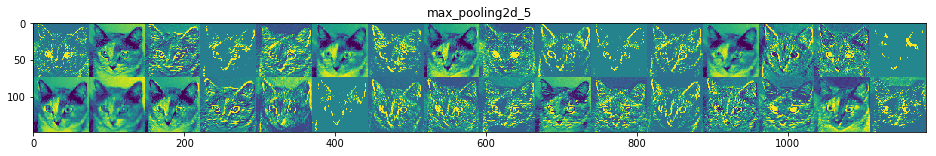

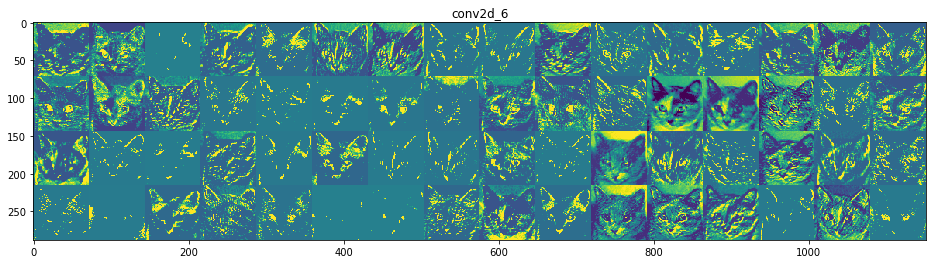

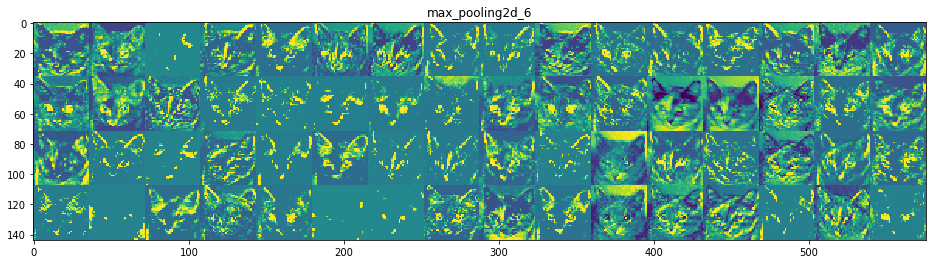

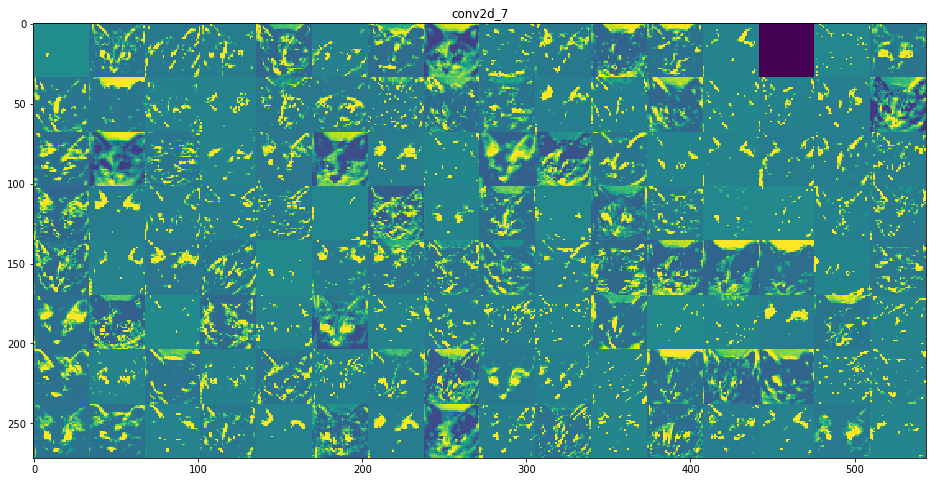

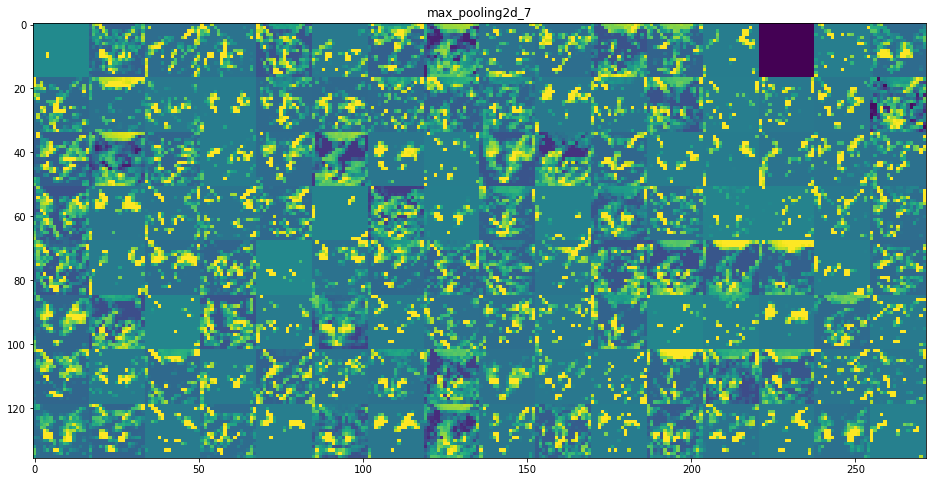

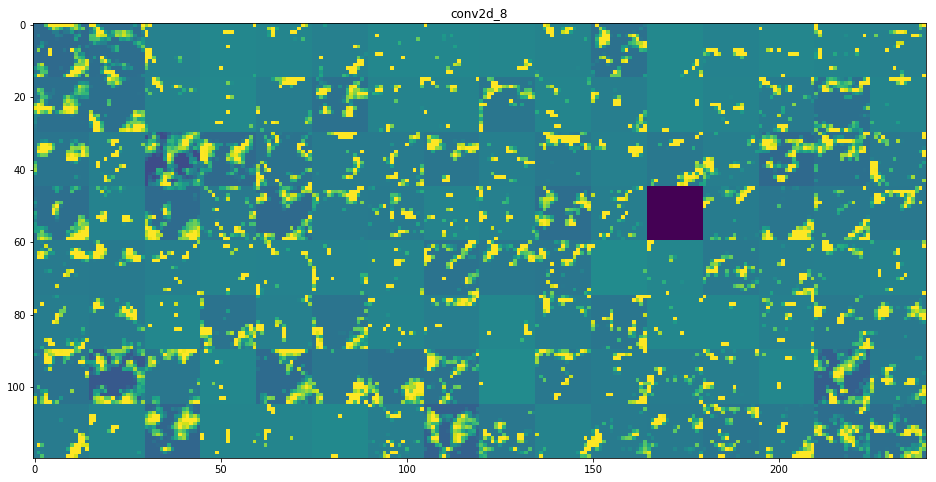

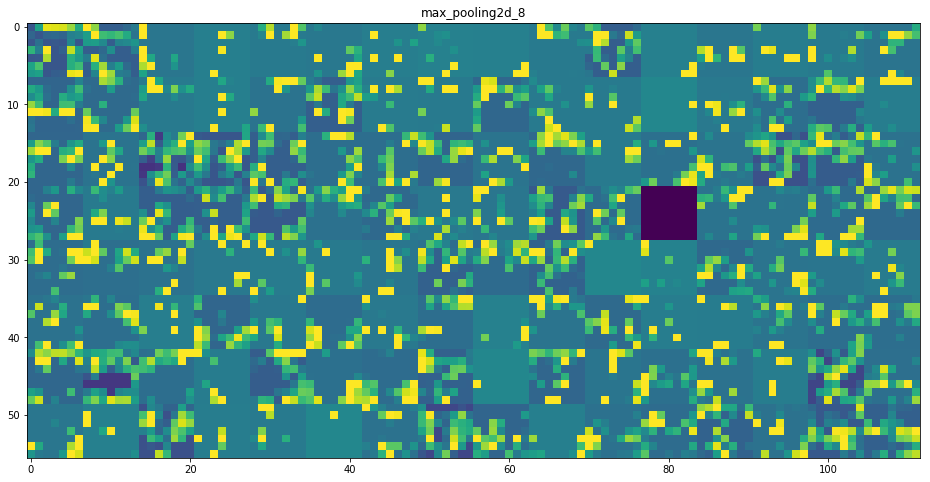

In [11]:
# Visualizing every channel in every intermediate activation

# Names of the layers, so you can
# have them as part of your plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

# Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # Number of features in the feature map
    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features).
    size = layer_activation.shape[1]
    
    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            
            # Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            # Displays the grid
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

There are a few things to note here:
* The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
* As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye”. Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

We have just evidenced an important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer.The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (bicycle, tree) but can’t remember the specific appearance of these objects. In fact, if you tried to draw a generic bicycle from memory, chances are you couldn't get it even remotely right, even though you’be seen thousands of bicycles in your lifetime.Try it right now: this effect is absolutely real. You brain has learned to completely abstract its visual input—to __transform it into high-level visual concepts__ while __filtering out irrelevant visual details__—__making it__ tremendously __difficult to remember how things around you look__.

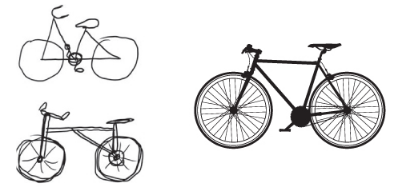

## 5.4.2 Visualizing convnet filters

Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. 